In [ ]:
# default_exp losses.pytorch

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch as t
import torch.nn as nn

In [ ]:
#export
def divide_no_nan(a, b):
    """
    Auxiliary funtion to handle divide by 0
    """
    div = a / b
    div[div != div] = 0.0
    div[div == float('inf')] = 0.0
    return div

# GENERAL TRAIN LOSSES

In [ ]:
#export
def MAPELoss(y, y_hat, mask=None):
    """MAPE Loss

    Calculates Mean Absolute Percentage Error between
    y and y_hat. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the
    percentual deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.
    As defined in: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    mape:
    Mean absolute percentage error.
    """
    mask = divide_no_nan(mask, t.abs(y))
    mape = t.abs(y - y_hat) * mask
    mape = t.mean(mape)
    return mape

In [ ]:
# export
def MSELoss(y, y_hat, mask=None):
    """MSE Loss

    Calculates Mean Squared Error between
    y and y_hat. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the
    percentual deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    mse:
    Mean Squared Error.
    """
    mse = (y - y_hat)**2
    mse = mask * mse
    mse = t.mean(mse)
    return mse

In [ ]:
# export
def RMSELoss(y, y_hat, mask=None):
    """RMSE Loss

    Calculates Mean Squared Error between
    y and y_hat. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the
    percentual deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    rmse:
    Root Mean Squared Error.
    """
    rmse = (y - y_hat)**2
    rmse = mask * rmse
    rmse = t.sqrt(t.mean(rmse))
    return rmse

In [ ]:
# export
def SMAPELoss(y, y_hat, mask=None):
    """SMAPE2 Loss

    Calculates Symmetric Mean Absolute Percentage Error.
    SMAPE measures the relative prediction accuracy of a
    forecasting method by calculating the relative deviation
    of the prediction and the true value scaled by the sum of the
    absolute values for the prediction and true value at a
    given time, then averages these devations over the length
    of the series. This allows the SMAPE to have bounds between
    0% and 200% which is desireble compared to normal MAPE that
    may be undetermined.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.

    Returns
    -------
    smape:
        symmetric mean absolute percentage error

    References
    ----------
    [1] https://robjhyndman.com/hyndsight/smape/ (Makridakis 1993)
    """
    if mask is None:
        mask = t.ones(y_hat.size())
    delta_y = t.abs((y - y_hat))
    scale = t.abs(y) + t.abs(y_hat)
    smape = divide_no_nan(delta_y, scale)
    smape = smape * mask
    smape = 2 * t.mean(smape)
    return smape

In [ ]:
# export
def MASELoss(y, y_hat, y_insample, seasonality, mask=None) :
    """ Calculates the M4 Mean Absolute Scaled Error.

    MASE measures the relative prediction accuracy of a
    forecasting method by comparinng the mean absolute errors
    of the prediction and the true value against the mean
    absolute errors of the seasonal naive model.

    Parameters
    ----------
    seasonality: int
        main frequency of the time series
        Hourly 24,  Daily 7, Weekly 52,
        Monthly 12, Quarterly 4, Yearly 1
    y: tensor (batch_size, output_size)
        actual test values
    y_hat: tensor (batch_size, output_size)
        predicted values
    y_train: tensor (batch_size, input_size)
        actual insample values for Seasonal Naive predictions

    Returns
    -------
    mase:
        mean absolute scaled error

    References
    ----------
    [1] https://robjhyndman.com/papers/mase.pdf
    """
    if mask is None:
        mask = t.ones(y_hat.size())
    delta_y = t.abs(y - y_hat)
    scale = t.mean(t.abs(y_insample[:, seasonality:] - \
                            y_insample[:, :-seasonality]), axis=1)
    mase = divide_no_nan(delta_y, scale[:, None])
    mase = mase * mask
    mase = t.mean(mase)
    return mase

In [ ]:
# export
def MAELoss(y, y_hat, mask=None):
    """MAE Loss

    Calculates Mean Absolute Error between
    y and y_hat. MAE measures the relative prediction
    accuracy of a forecasting method by calculating the
    deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    mae:
    Mean absolute error.
    """
    mae = t.abs(y - y_hat) * mask
    mae = t.mean(mae)
    return mae

In [ ]:
# export
def PinballLoss(y, y_hat, mask=None, tau=0.5):
    """Pinball Loss
    Computes the pinball loss between y and y_hat.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    tau: float, between 0 and 1
        the slope of the pinball loss, in the context of
        quantile regression, the value of tau determines the
        conditional quantile level.

    Returns
    -------
    pinball:
        average accuracy for the predicted quantile
    """
    if mask is None:
        mask = t.ones(y_hat.size())
    delta_y = t.sub(y, y_hat)
    pinball = t.max(t.mul(tau, delta_y), t.mul((tau - 1), delta_y))
    pinball = pinball * mask
    pinball = t.mean(pinball)
    return pinball

# ESRNN TRAIN LOSSES

In [ ]:
#export
def LevelVariabilityLoss(levels, level_variability_penalty):
    """ Level Variability Loss
    Computes the variability penalty for the level.

    Parameters
    ----------
    levels: tensor with shape (batch, n_time)
        levels obtained from exponential smoothing component of ESRNN
    level_variability_penalty: float
        this parameter controls the strength of the penalization 
        to the wigglines of the level vector, induces smoothness
        in the output
    
    Returns
    ----------
    level_var_loss:
        wiggliness loss for the level vector
    """
    assert levels.shape[1] > 2
    level_prev = t.log(levels[:, :-1])
    level_next = t.log(levels[:, 1:])
    log_diff_of_levels = t.sub(level_prev, level_next)

    log_diff_prev = log_diff_of_levels[:, :-1]
    log_diff_next = log_diff_of_levels[:, 1:]
    diff = t.sub(log_diff_prev, log_diff_next)
    level_var_loss = diff**2
    level_var_loss = level_var_loss.mean() * level_variability_penalty
    
    return level_var_loss

In [ ]:
#export
def SmylLoss(y, y_hat, levels, mask, tau, level_variability_penalty=0.0):
    """Computes the Smyl Loss that combines level variability with
    with Pinball loss.
    windows_y: tensor of actual values,
                            shape (n_windows, batch_size, window_size).
    windows_y_hat: tensor of predicted values,
                                    shape (n_windows, batch_size, window_size).
    levels: levels obtained from exponential smoothing component of ESRNN.
                    tensor with shape (batch, n_time).
    return: smyl_loss.
    """
    
    if mask is None: mask = t.ones(y_hat.size())
    smyl_loss = PinballLoss(y, y_hat, mask, tau)
    
    if level_variability_penalty > 0:
        log_diff_of_levels = LevelVariabilityLoss(levels, level_variability_penalty) 
        smyl_loss += log_diff_of_levels
    
    return smyl_loss

# MULTI-QUANTILE LOSS

MQLoss definition and testing

In [ ]:
#export
def MQLoss(y, y_hat, quantiles, mask=None): 
    """MQLoss

    Calculates Average Multi-quantile Loss function, for
    a given set of quantiles, based on the absolute 
    difference between predicted and true values.

    Parameters
    ----------
    y: tensor (batch_size, output_size) actual values in torch tensor.
    y_hat: tensor (batch_size, output_size, n_quantiles) predicted values in torch tensor.
    mask: tensor (batch_size, output_size, n_quantiles) specifies date stamps per serie
          to consider in loss
    quantiles: tensor(n_quantiles) quantiles to estimate from the distribution of y.

    Returns
    -------
    lq: tensor(n_quantiles) average multi-quantile loss.
    """    
    assert len(quantiles) > 1, f'your quantiles are of len: {len(quantiles)}'
    
    if mask is None: mask = t.ones_like(y_hat)
        
    n_q = len(quantiles)
    
    y_rep = t.stack([y.T for _ in range(n_q)]).T
    error = y_hat - y_rep
    sq = t.maximum(-error, t.zeros_like(error))
    s1_q = t.maximum(error, t.zeros_like(error))
    loss = (quantiles * sq + (1 - quantiles) * s1_q)
   
    return t.mean(t.mean(loss, axis=1))

In [ ]:
#export
def wMQLoss(y, y_hat, quantiles, mask=None): 
    """wMQLoss

    Calculates Average Multi-quantile Loss function, for
    a given set of quantiles, based on the absolute 
    difference between predicted and true values.

    Parameters
    ----------
    y: tensor (batch_size, output_size) actual values in torch tensor.
    y_hat: tensor (batch_size, output_size, n_quantiles) predicted values in torch tensor.
    mask: tensor (batch_size, output_size, n_quantiles) specifies date stamps per serie
          to consider in loss
    quantiles: tensor(n_quantiles) quantiles to estimate from the distribution of y.

    Returns
    -------
    lq: tensor(n_quantiles) average multi-quantile loss.
    """    
    assert len(quantiles) > 1, f'your quantiles are of len: {len(quantiles)}'
    
    if mask is None: mask = t.ones_like(y_hat)
        
    n_q = len(quantiles)
    
    y_rep = t.stack([y.T for _ in range(n_q)]).T
    error = y_hat - y_rep
    sq = t.maximum(-error, t.zeros_like(error))
    s1_q = t.maximum(error, t.zeros_like(error))
    loss = (quantiles * sq + (1 - quantiles) * s1_q)
    
    loss = divide_no_nan(t.sum(loss * mask, axis=-2), 
                         t.sum(t.abs(y_rep) * mask, axis=-2))
    
    return t.mean(loss)

# TEST/DEBUG PYTORCH TRAIN LOSSES

In [ ]:
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import time
from scipy.stats import hmean
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Model(nn.Module):  

    def __init__(self, horizon, n_quantiles):
        super(Model, self).__init__()
        self.horizon = horizon
        self.n_quantiles = n_quantiles
        self.linear_layer = nn.Linear(in_features=n_obs, 
                                      out_features=horizon * n_quantiles, 
                                      bias=False)

    def forward(self, x):
        y_hat = self.linear_layer(x)
        y_hat = y_hat.view(-1, self.horizon, self.n_quantiles)
        return y_hat
    
class Data(Dataset):
    
    # Constructor
    def __init__(self, Y, X):
        self.X = X
        self.Y = Y
        self.len = Y.shape[0]

    # Getter
    def __getitem__(self, index):          
        return self.X[index], self.Y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [ ]:
# Hyperparameters and sample data parameters
t.cuda.manual_seed(7)

# Sample data
n_ts = 1000
n_obs = horizon = 10
mean = 0.0 # to generate random numbers from N(mean, std)
std = 7.0 # to generate random numbers from N(mean, std)
start = 0.05 # First quantile
end = 0.95 # Last quantiles
steps = 4 # Number of quantiles

# Hyperparameters
batch_size = 500
lr = 0.08
epochs = 100

# Sample data
quantiles = t.Tensor([0.0500, 0.3500, 0.6500, 0.9500])
print(f'quantiles:\n{quantiles}')
Y = t.normal(mean=mean, std=std, size=(n_ts, n_obs))
X = t.ones(size=(n_ts, n_obs))

Y_test = t.normal(mean=mean, std=std, size=(n_ts, horizon))
X_test = t.ones(size=(n_ts, horizon))
print(f'Y.shape: {Y.shape}, X.shape: {X.shape}')
print(f'Y_test.shape: {Y_test.shape}, X_test.shape: {X_test.shape}')

quantiles:
tensor([0.0500, 0.3500, 0.6500, 0.9500])
Y.shape: torch.Size([1000, 10]), X.shape: torch.Size([1000, 10])
Y_test.shape: torch.Size([1000, 10]), X_test.shape: torch.Size([1000, 10])


In [ ]:
# Model training 
model = Model(horizon=horizon, n_quantiles=len(quantiles))
dataset = Data(X=X, Y=Y)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_model(model, epochs, print_progress=False):

    start = time.time()
    i = 0 
    training_trajectory = {'epoch': [],
                           'train_loss': []}
    
    for epoch in range(epochs):
        for x, y in dataloader:
            
            i += 1
            y_hat = model(x)
            training_loss = wMQLoss(y=y, y_hat=y_hat, quantiles=quantiles)
            if i % (epoch + 1) == 0: 
                training_trajectory['epoch'].append(i)
                training_trajectory['train_loss'].append(training_loss.detach().numpy())
            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()

            display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(i, 
                                                                                    time.time()-start, 
                                                                                    "MQLoss", 
                                                                                    training_loss.cpu().data.numpy())
            if print_progress: print(display_string)

    return model, training_trajectory

model, training_trajectory = train_model(model=model, epochs=epochs)
Y_hat = model(X_test).detach()

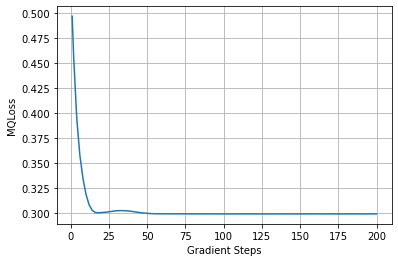

In [ ]:
plt.plot(training_trajectory['epoch'], training_trajectory['train_loss'])
plt.xlabel('Gradient Steps')
plt.ylabel('MQLoss')
plt.grid()
plt.show()

In [ ]:
from nixtla.losses.numpy import mqloss

loss_pytorch = MQLoss(Y_test, Y_hat, quantiles)
loss_numpy = mqloss(Y_test.numpy(), Y_hat.numpy(), quantiles.numpy())

print(f'loss_pytorch: {loss_pytorch}')
print(f'loss_numpy: {loss_numpy}')
print(f'Difference: {abs(loss_pytorch - loss_numpy)}')

loss_pytorch: 1.6508954763412476
loss_numpy: 1.650895595550537
Difference: 1.1920928955078125e-07
